# Spacecraft with reaction wheels and star tracker

Abstract: The goal of this project is to design, implement and test a controller that controls the four reaction wheels of a satellite to maintain its initial attitude, and an observer that collects data on the position of stars and estimates the state vector of the system. This report will discuss the design process, features and shortcomings of the controller and the observer. All the simulations are designed and run in this Jupyter notebook environment.

Import modules and configure the notebook.

In [1]:
# This module is part of the python standard library
import time

# These modules are part of other existing libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
import sympy as sym

# This is my own script (it is an interface to the pybullet simulator)
import ae353_spacecraft

# I often go back and forth between making changes to my scripts and to
# the notebook in which they are used. One "gotcha" is that notebooks only
# import modules or scripts ONCE. Subsequent imports don't do anything, and
# in particular won't reflect any changes I've made to my scripts. To make
# sure that I'm working with the latest version of my code, I use this bit
# of magic, which forces the notebook to "reload" my script:
import importlib
importlib.reload(ae353_spacecraft)

<module 'ae353_spacecraft' from 'c:\\Users\\anshu\\Desktop\\Class Materials\\AE 353 Git\\ae353-sp21\\projects\\03_spacecraft\\03_code\\ae353_spacecraft.py'>

## Deriving the equations of motion of the controller

First, we work on the controller design. The next few cells derive the equations of motion using symbolic math. This can slow down the notebook as a whole, and so these sections are commented out unless necessary.

In [2]:
mb = 6.
Jxb = 10.
Jyb = 10.
Jzb = 16.

mw = 1.
Jxw = 0.075
Jyw = 0.075
Jzw = 0.125
lw = 1.1

# roll, pitch, yaw angles
phi, theta, psi = sym.symbols('phi, theta, psi')

# angular velocities
w_x, w_y, w_z = sym.symbols('w_x, w_y, w_z')

# torques
tau_1, tau_2, tau_3, tau_4 = sym.symbols('tau_1, tau_2, tau_3, tau_4')

# resultant torques
lt = sym.nsimplify(lw) * sym.sqrt(2) / 2
T1 = - tau_1 * sym.Matrix([[lt], [0], [lt]])
T2 = - tau_2 * sym.Matrix([[-lt], [0], [lt]])
T3 = - tau_3 * sym.Matrix([[0], [lt], [lt]])
T4 = - tau_4 * sym.Matrix([[0], [-lt], [lt]])
T = T1 + T2 + T3 + T4

# parameters
Jx = sym.nsimplify(Jxb + 4 * mw * lw**2)
Jy = sym.nsimplify(Jyb + 4 * mw * lw**2)
Jz = sym.nsimplify(Jzb + 4 * mw * lw**2)

# rotation matrices
Rx = sym.Matrix([[1, 0, 0], [0, sym.cos(phi), -sym.sin(phi)], [0, sym.sin(phi), sym.cos(phi)]])
Ry = sym.Matrix([[sym.cos(theta), 0, sym.sin(theta)], [0, 1, 0], [-sym.sin(theta), 0, sym.cos(theta)]])
Rz = sym.Matrix([[sym.cos(psi), -sym.sin(psi), 0], [sym.sin(psi), sym.cos(psi), 0], [0, 0, 1]])

# angular velocity to angular rates
ex = sym.Matrix([[1], [0], [0]])
ey = sym.Matrix([[0], [1], [0]])
ez = sym.Matrix([[0], [0], [1]])
M = sym.simplify(sym.Matrix.hstack((Ry * Rz).T * ex, Rz.T * ey, ez).inv(), full=True)

# euler's equations
euler = sym.Matrix([[(1 / Jx) * (T[0] + (Jy - Jz) * w_y * w_z)],
                   [(1 / Jy) * (T[1] + (Jz - Jx) * w_z * w_x)],
                   [(1 / Jz) * (T[2] + (Jx - Jy) * w_x * w_y)]])

# equations of motion
f = sym.simplify(sym.Matrix.vstack(M * sym.Matrix([[w_x], [w_y], [w_z]]), euler), full=True)

In [3]:
f

Matrix([
[                        (w_x*cos(psi) - w_y*sin(psi))/cos(theta)],
[                                     w_x*sin(psi) + w_y*cos(psi)],
[        -w_x*cos(psi)*tan(theta) + w_y*sin(psi)*tan(theta) + w_z],
[-55*sqrt(2)*tau_1/1484 + 55*sqrt(2)*tau_2/1484 - 150*w_y*w_z/371],
[-55*sqrt(2)*tau_3/1484 + 55*sqrt(2)*tau_4/1484 + 150*w_x*w_z/371],
[                -55*sqrt(2)*(tau_1 + tau_2 + tau_3 + tau_4)/2084]])

In [4]:
# Make f an executable function
f_num = sym.lambdify((phi, theta, psi, w_x, w_y, w_z,tau_1, tau_2, tau_3, tau_4),f)

In [5]:
#Equilibrium values. For our system, these are all zero

phi_e = 0
theta_e = 0
psi_e = 0
w_x_e = 0
w_y_e = 0
w_z_e = 0
tau_1_e = 0
tau_2_e = 0
tau_3_e = 0
tau_4_e = 0

In [6]:
# We can then check the equilibrium value of the 
feq = f_num(phi_e, theta_e
, psi_e
, w_x_e
, w_y_e
, w_z_e
, tau_1_e
, tau_2_e
, tau_3_e
, tau_4_e)

## Linearizing the system
This is mainly for the first equation in the state space model. The second equation we'll get to when designing the observer
$$\dot{x} = Ax + Bu$$

In [7]:
# Now we linearize our system about the equilibrium point
# Linearizing the system

#Now we find the Jacobians
f_jacob_x = f.jacobian([phi, theta, psi, w_x, w_y, w_z])
f_jacob_u = f.jacobian([tau_1, tau_2, tau_3, tau_4])

#And then we find functions for A and B using this jacobian
A_num = sym.lambdify((phi, theta, psi, w_x, w_y, w_z,tau_1, tau_2, tau_3, tau_4),f_jacob_x)
B_num = sym.lambdify((phi, theta, psi, w_x, w_y, w_z,tau_1, tau_2, tau_3, tau_4),f_jacob_u)

#Finally, we find the linearized state space model by evaluating A_num and B_num at the equilibrium points
A = A_num(phi_e, theta_e, psi_e, w_x_e, w_y_e, w_z_e,tau_1_e, tau_2_e, tau_3_e, tau_4_e).astype(float)
B = B_num(phi_e, theta_e, psi_e, w_x_e, w_y_e, w_z_e,tau_1_e, tau_2_e, tau_3_e, tau_4_e).astype(float)


In [8]:
A

array([[ 0.,  0.,  0.,  1., -0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0., -0.,  0.,  1.],
       [ 0.,  0.,  0.,  0., -0., -0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.]])

In [9]:
B

array([[ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [-0.05241358,  0.05241358,  0.        ,  0.        ],
       [ 0.        ,  0.        , -0.05241358,  0.05241358],
       [-0.03732329, -0.03732329, -0.03732329, -0.03732329]])

## Checking for controllability
We need to make sure that this system we've chosen is controllable. To do this, we calculate the controllability matrix $W$

In [10]:
## Checking for controllability
# Find the number of states
n = A.shape[0]

# Initialize W with its first column
Wc = B

# Create W one column at a time by iterating over i from 1 to n-1
for i in range(1, n):
    col = np.linalg.matrix_power(A, i) @ B
    Wc = np.block([Wc, col])

In [11]:
# What about the rank?
print(np.linalg.matrix_rank(Wc))
print(Wc.shape)

6
(6, 24)


The controllability matrix is full rank, so the system is controllable

## LQR design for the controller

In [12]:
Qc = np.diag([0.5,1.,1.,0.25,0.4,0.4]) #Roll, pitch, yaw, omegax, omegay, omegaz
Rc = np.diag([1.,1.,1.,1.]) #Tau 1 to tau 4
# We can also define an LQR function in the following way:
def lqr(A,B,Q,R):
    P = linalg.solve_continuous_are(A,B,Q,R)
    K = linalg.inv(R) @ B.T @ P
    return K
# The function above can be used for both controller and observer design
K = lqr(A,B,Qc,Rc)

In [13]:
F = A - B@K
s = linalg.eigvals(F)
print(s.real < 0) ## Stable

[ True  True  True  True  True  True]


## Deriving Equations of Motion for Observer

Now that the controller is designed, we need to work on the design of the observer. This depends on the number of stars used. For now, we'll use 5 stars. 

In [14]:
# Now we work on the Observer
alpha, delta = sym.symbols('alpha, delta')
# Scope radius
r = 0.8 / 2.1
# Position of star in space frame
p_star_in_space = sym.Matrix([[sym.cos(alpha) * sym.cos(delta)],
                              [sym.sin(alpha) * sym.cos(delta)],
                              [sym.sin(delta)]])

# Orientation of body frame in space frame
R_body_in_space = Rx * Ry * Rz

# Position of star in body frame (assuming origin of body and space frames are the same)
p_star_in_body = R_body_in_space.T * p_star_in_space

# Position of star in image frame
p_star_in_image = (1 / sym.nsimplify(r)) * sym.Matrix([[p_star_in_body[1] / p_star_in_body[0]],
                                                       [p_star_in_body[2] / p_star_in_body[0]]])

# Sensor model for each star
g = sym.simplify(p_star_in_image, full=True)

Below we can see how the equations of motion look for a single star

In [15]:
g

Matrix([
[21*((sin(phi)*cos(psi) + sin(psi)*sin(theta)*cos(phi))*sin(delta) - (sin(phi)*sin(psi)*sin(theta) - cos(phi)*cos(psi))*sin(alpha)*cos(delta) - sin(psi)*cos(alpha)*cos(delta)*cos(theta))/(8*((sin(phi)*sin(psi) - sin(theta)*cos(phi)*cos(psi))*sin(delta) + (sin(phi)*sin(theta)*cos(psi) + sin(psi)*cos(phi))*sin(alpha)*cos(delta) + cos(alpha)*cos(delta)*cos(psi)*cos(theta)))],
[                                                                      21*(-sin(alpha)*sin(phi)*cos(delta)*cos(theta) + sin(delta)*cos(phi)*cos(theta) + sin(theta)*cos(alpha)*cos(delta))/(8*((sin(phi)*sin(psi) - sin(theta)*cos(phi)*cos(psi))*sin(delta) + (sin(phi)*sin(theta)*cos(psi) + sin(psi)*cos(phi))*sin(alpha)*cos(delta) + cos(alpha)*cos(delta)*cos(psi)*cos(theta)))]])

Now we can have multiple copies of these equations of motion to get the full set.


In [16]:
#Make G a combination of 5 stars with set position data
alpha1 = 0.
delta1 = 0.
alpha2 = 0.15
delta2 = 0.
alpha3 = 0
delta3 = 0.15
alpha4 = -0.2
delta4 = 0
alpha5 = 0.3
delta5 = -0.2

G = np.block([[g.subs([(alpha, alpha1), (delta, delta1)])],[g.subs([(alpha, alpha2), (delta, delta2)])],[g.subs([(alpha, alpha3), (delta, delta3)])],[g.subs([(alpha, alpha4), (delta, delta4)])],[g.subs([(alpha, alpha5), (delta, delta5)])]])
G = sym.Matrix(G)
G

Matrix([
[                                                                                                                                                                                                                                                                                                                                                                                                                           -21*sin(psi)/(8*cos(psi))],
[                                                                                                                                                                                                                                                                                                                                                                                                               21*sin(theta)/(8*cos(psi)*cos(theta))],
[                                                                                                              

In [17]:
# We also need to find the equilibrium value of this system and subtract that from the sensor measurements to get y
G_num = sym.lambdify((phi, theta, psi),G)
Geq = G_num(phi_e, theta_e, psi_e)
Geq.tolist()

[[-0.0],
 [0.0],
 [0.3967299474030241],
 [0.0],
 [0.0],
 [0.3967299474030241],
 [-0.5321138432102644],
 [0.0],
 [0.8120076552252624],
 [-0.5569910175809305]]

## Linearizing and Observability

We now linearize this system to get the $C$ matrix

In [18]:
#We now create a numerical function for C, that will then be evaluated at the equilibrium point
C_num = sym.lambdify((phi, theta, psi), G.jacobian([phi, theta, psi, w_x, w_y, w_z]))
C = C_num(phi_e, theta_e, psi_e)
C

array([[ 0.        ,  0.        , -2.625     ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  2.625     ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        , -2.68495987,  0.        ,  0.        ,
         0.        ],
       [-0.39672995,  2.625     , -0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.39672995,  0.        , -2.625     ,  0.        ,  0.        ,
         0.        ],
       [-0.        ,  2.68495987,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        , -2.73286482,  0.        ,  0.        ,
         0.        ],
       [ 0.53211384,  2.625     ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-0.55699102, -0.17229751, -2.8761834 ,  0.        ,  0.        ,
         0.        ],
       [-0.81200766,  2.74318628,  0.17229751,  0.        ,  0.        ,
         0.        ]])

In [19]:
# We can check for the observability of this system
Wo = C
for i in range(1,n):
    row = C @ np.linalg.matrix_power(A,i)
    Wo = np.block([[Wo],[row]])
rank = np.linalg.matrix_rank(Wo)
print(rank)
# The rank of the system is the same as the number of states, so the system is observable.

6


## Optimal Observer Design
Since the system is observable, we can use LQR to find the optimal observer.

In [20]:
# Designing an optimal controller
Qo = np.diag(np.ones(2*5)) # (2n)x(2n) for an n star system
Ro = 0.05*np.diag([1.,1.,1.,1.,1.,1.])

L = lqr(A.T, C.T, linalg.inv(Ro), linalg.inv(Qo)).T

In [21]:
H  = A - L@C
so = linalg.eigvals(H)
print(so.real < 0)

[ True  True  True  True  True  True]


# Simulation
With all the values set in place, we can run the simulation and find the results

In [22]:
class RobotController:
    def __init__(self, A, B, C, K, L, Geq):
        self.dt = 0.01
        self.K = K
        self.L = L
        self.A = A
        self.C = C
        self.B = B
        self.Geq = Geq 
        # All the equilibrium values were chosen to be 0, so they are not defined here
        self.reset()
    
    def reset(self):
        self.xhat = np.zeros((6, 1))
    
    def run(self, p, v):
        z = np.array([p]).T
        y = np.array(z - self.Geq)
        u = -self.K @ self.xhat
        tau = np.array([u[0,0], u[1,0], u[2,0], u[3,0]])
        xhatold = self.xhat
        for i in range(self.xhat.shape[0]):
            if np.isnan(self.xhat[i,0]):
                self.xhat[i,0] = xhatold[i,0]
        self.xhat += self.dt * (self.A @ self.xhat + self.B @ u - self.L @ (self.C@self.xhat  - y))
        return tau

controller = RobotController(A, B, C, K, L, Geq)

Now we can create an instance of the simulation

In [23]:
robot = ae353_spacecraft.RobotSimulator(display=False, shootingstar = True, stars = np.array([[alpha1,delta1],[alpha2,delta2],[alpha3,delta3],[alpha4,delta4],[alpha5,delta5]]), scope_noise=0.1)

We can create a snapshot to see the arrangement of the stars

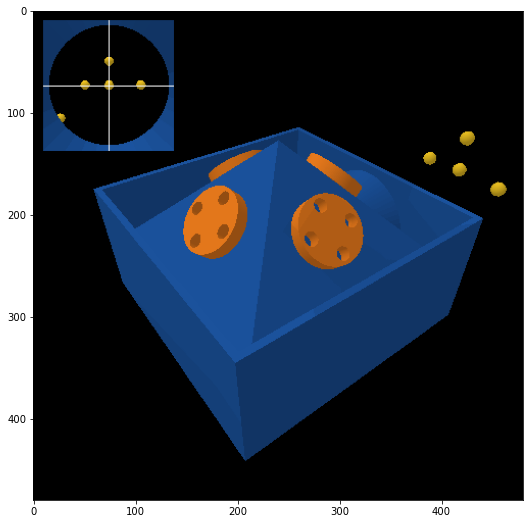

In [24]:
# Get snapshot as 480 x 480 x 4 numpy array of RGBA values
rgba = robot.snapshot()

# Display snapshot
plt.figure(figsize=(9, 9))
plt.imshow(rgba)

In [25]:
plt.imsave('my_snapshot.png', rgba)

In [26]:
# Restore the simulation to its initial state
robot.reset()

# Restore the controller to its initial state
controller.reset()

# Choose how long we want to run the simulation, and
# compute the corresponding number of time steps
run_time =  50
num_steps = int(run_time/robot.dt)

# Create a dictionary in which to store results
data = {
    't': np.empty(num_steps, dtype=float),
    'v': np.empty((4, num_steps), dtype=float),
    'p': np.empty((2 * len(robot.stars), num_steps), dtype=float),
    'tau': np.empty((4, num_steps), dtype=float),
    'rpy': np.empty((3, num_steps), dtype=float),
    'angvel': np.empty((3, num_steps), dtype=float),
    'xhat': np.empty((6, num_steps), dtype=float),
}

p = np.zeros(10) #CHANGE this when changing no. of stars
v = np.zeros(4)
# Run the simulation loop
start_time = time.time()
for step in range(num_steps):
    # Get the current time
    t = robot.dt * step
    pold = p
    vold = v
    # Get the sensor measurements
    p, v = robot.get_sensor_measurements()
    # Ensuring we don't get nan values
    for i in range(p.shape[0]):
        if np.isnan(p[i]):
            p[i] = pold[i]
    # Choose the actuator command (by running the controller)
    tau = controller.run(p, v)
    if tau.shape != (4, ):
        raise Exception(f'invalid desired torques: {tau}')
    
    # Get orientation and angular velocity as ground truth
    rpy, angvel = robot.get_rpy_and_angvel()
        
    # Log the data from this time step
    data['t'][step] = t
    data['v'][:, step] = v
    data['p'][:, step] = p
    data['tau'][:, step] = tau
    data['rpy'][:, step] = rpy
    data['angvel'][:, step] = angvel
    data['xhat'][:, step] = controller.xhat.flatten()
    
    # Send the actuator commands to robot and go forward one time step
    robot.set_actuator_commands(tau)
    robot.step(t=(start_time + (robot.dt * (step + 1))))
    
print(f'elapsed time: {time.time() - start_time:.1f}')

elapsed time: 0.7


Plot the results

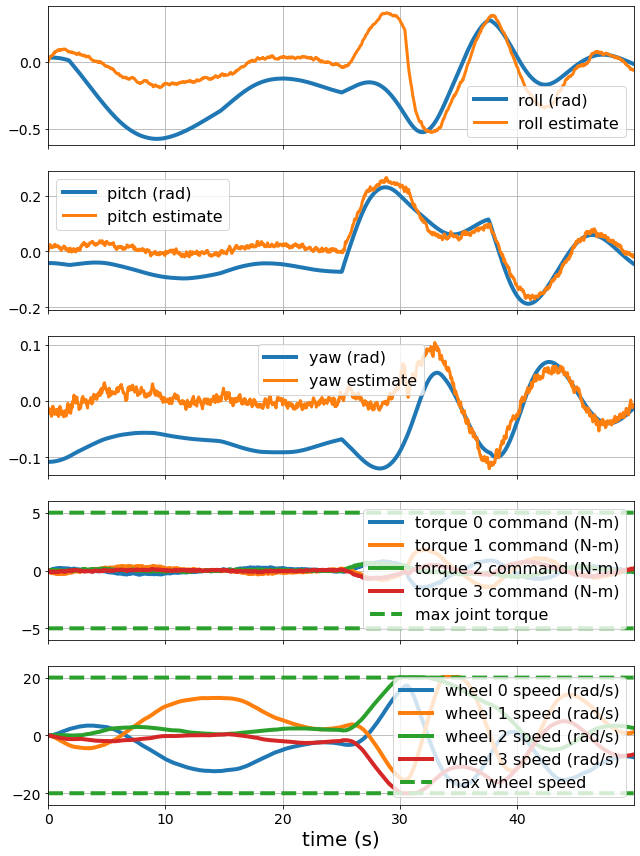

In [27]:
# Create a figure with subplots that all share the same x-axis
fig, (ax_r,ax_p, ax_y, ax_tau, ax_v) = plt.subplots(5, 1, figsize=(9, 12), sharex=True)

# Roll, pitch, and yaw angles
ax_r.plot(data['t'], data['rpy'][0, :], label='roll (rad)', linewidth=4)
ax_r.plot(data['t'], data['xhat'][0, :], label='roll estimate', linewidth=3)

ax_p.plot(data['t'], data['rpy'][1, :], label='pitch (rad)', linewidth=4)
ax_p.plot(data['t'], data['xhat'][1, :], label='pitch estimate', linewidth=3)

ax_y.plot(data['t'], data['rpy'][2, :], label='yaw (rad)', linewidth=4)
ax_y.plot(data['t'], data['xhat'][2, :], label='yaw estimate', linewidth=3)

ax_r.grid()
ax_r.legend(fontsize=16)
ax_r.tick_params(labelsize=14)
ax_p.grid()
ax_p.legend(fontsize=16)
ax_p.tick_params(labelsize=14)
ax_y.grid()
ax_y.legend(fontsize=16)
ax_y.tick_params(labelsize=14)

# Wheel torques
for i in range(4):
    ax_tau.plot(data['t'], data['tau'][i, :], label=f'torque {i} command (N-m)', linewidth=4)
ax_tau.plot(data['t'], np.ones_like(data['t']) * robot.tau_max, '--', label='max joint torque', linewidth=4, color='C2')
ax_tau.plot(data['t'], -np.ones_like(data['t']) * robot.tau_max, '--', linewidth=4, color='C2')
ax_tau.grid()
ax_tau.legend(fontsize=16)
ax_tau.tick_params(labelsize=14)
ax_tau.set_ylim(-1.2 * robot.tau_max, 1.2 * robot.tau_max)

# Wheel speeds
for i in range(4):
    ax_v.plot(data['t'], data['v'][i, :], label=f'wheel {i} speed (rad/s)', linewidth=4)
ax_v.plot(data['t'], np.ones_like(data['t']) * robot.v_max, '--', label='max wheel speed', linewidth=4, color='C2')
ax_v.plot(data['t'], -np.ones_like(data['t']) * robot.v_max, '--', linewidth=4, color='C2')
ax_v.grid()
ax_v.legend(fontsize=16)
ax_v.tick_params(labelsize=14)
ax_v.set_ylim(-1.2 * robot.v_max, 1.2 * robot.v_max)

# Set shared x-axis properties
ax_v.set_xlabel('time (s)', fontsize=20)
ax_v.set_xlim([data['t'][0], data['t'][-1]])

# Make the arrangement of subplots look nice
fig.tight_layout()

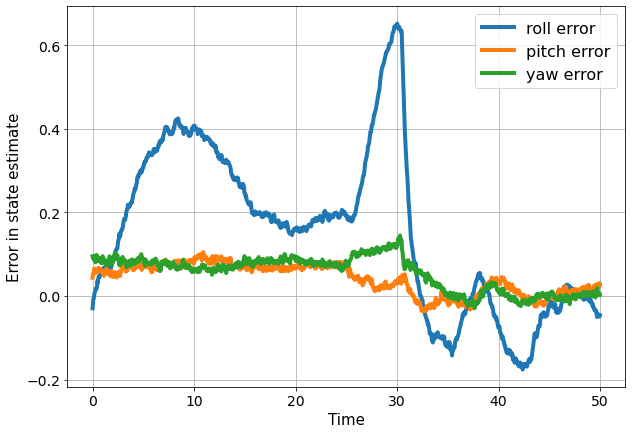

In [28]:
# We can plot the error in the estimate with time
# Create a figure with subplots that all share the same x-axis
# Roll, pitch, and yaw angles
plt.figure(figsize=(10,7))
plt.plot(data['t'], data['xhat'][0, :] - data['rpy'][0, :], label='roll error', linewidth=4)
plt.plot(data['t'], data['xhat'][1, :] - data['rpy'][1, :], label='pitch error', linewidth=4)
plt.plot(data['t'], data['xhat'][2, :] - data['rpy'][2, :], label='yaw error', linewidth=4)
plt.xlabel("Time", fontsize = 15)
plt.ylabel("Error in state estimate", fontsize = 15)
plt.grid()
plt.legend(fontsize=16)
plt.tick_params(labelsize=14)

We can also plot the star positions. This wasn't used in the report

(-1.0, 1.0)

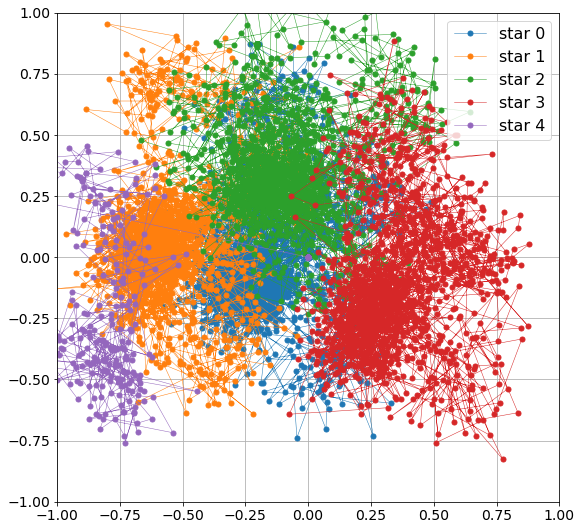

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(9, 9))
for i in range(len(robot.stars)):
    y = data['p'][2 * i, :]
    z = data['p'][2 * i + 1, :]
    ax.plot(-y, z, label=f'star {i}', linewidth=0.5, marker='.', markersize=10)
ax.grid()
ax.legend(fontsize=16)
ax.tick_params(labelsize=14)
ax.set_xlim(-1., 1.)
ax.set_ylim(-1., 1.)

## Multiple Runs

We can now work run this simulation many times to get an aggregate result, as each simulation has random factors that lead to different results each time.

Note for all the data after this point: The notebook was run again after the data from it was collected and placed in the report. This means that the data below  many not exactly match the in the report because of the randomness. However, since the simulation results are aggregated over 500 results, the diffence is likely to be small

In [30]:
# Run the simulation a hundred times
num_sims = 500
rpy_err = np.zeros((num_sims,3))
for j in range(num_sims):
    # Restore the simulation to its initial state
    robot.reset()
    # Restore the controller to its initial state
    controller.reset()

    # Choose how long we want to run the simulation, and
    # compute the corresponding number of time steps
    run_time = 30.0
    num_steps = int(run_time/robot.dt)

    # Create a dictionary in which to store results
    data = {
        't': np.empty(num_steps, dtype=float),
        'v': np.empty((4, num_steps), dtype=float),
        'p': np.empty((2 * len(robot.stars), num_steps), dtype=float),
        'tau': np.empty((4, num_steps), dtype=float),
        'rpy': np.empty((3, num_steps), dtype=float),
        'angvel': np.empty((3, num_steps), dtype=float),
        'xhat': np.empty((6, num_steps), dtype=float),
    }

    p = np.zeros(10) #CHANGE this when changing no. of stars
    v = np.zeros(4)
    # Run the simulation loop
    start_time = time.time()
    for step in range(num_steps):
        # Get the current time
        t = robot.dt * step
        pold = p
        vold = v
        # Get the sensor measurements
        p, v = robot.get_sensor_measurements()
        # Ensuring we don't get nan values
        for i in range(p.shape[0]):
            if np.isnan(p[i]):
                p[i] = pold[i]
        # Choose the actuator command (by running the controller)
        tau = controller.run(p, v)
        if tau.shape != (4, ):
            raise Exception(f'invalid desired torques: {tau}')
        
        # Get orientation and angular velocity as ground truth
        rpy, angvel = robot.get_rpy_and_angvel()
            
        # Log the data from this time step
        data['t'][step] = t
        data['v'][:, step] = v
        data['p'][:, step] = p
        data['tau'][:, step] = tau
        data['rpy'][:, step] = rpy
        data['angvel'][:, step] = angvel
        data['xhat'][:, step] = controller.xhat.flatten()
        
        # Send the actuator commands to robot and go forward one time step
        robot.set_actuator_commands(tau)
        robot.step(t=(start_time + (robot.dt * (step + 1))))
    rpy_err[j,0] += np.mean((data['rpy'][0, :])**2)
    rpy_err[j,1] += np.mean((data['rpy'][1, :])**2)
    rpy_err[j,2] += np.mean((data['rpy'][2, :])**2)
    if j%10 == 0:
        print(f'{j}/{num_sims}')
print(f'{num_sims}/{num_sims}')

0/500
10/500
20/500
30/500
40/500
50/500
60/500
70/500
80/500
90/500
100/500
110/500
120/500
130/500
140/500
150/500
160/500
170/500
180/500
190/500
200/500
210/500
220/500
230/500
240/500
250/500
260/500
270/500
280/500
290/500
300/500
310/500
320/500
330/500
340/500
350/500
360/500
370/500
380/500
390/500
400/500
410/500
420/500
430/500
440/500
450/500
460/500
470/500
480/500
490/500
500/500


Plotting the histogram results

Text(0.5, 0, 'Mean Square Error of Yaw')

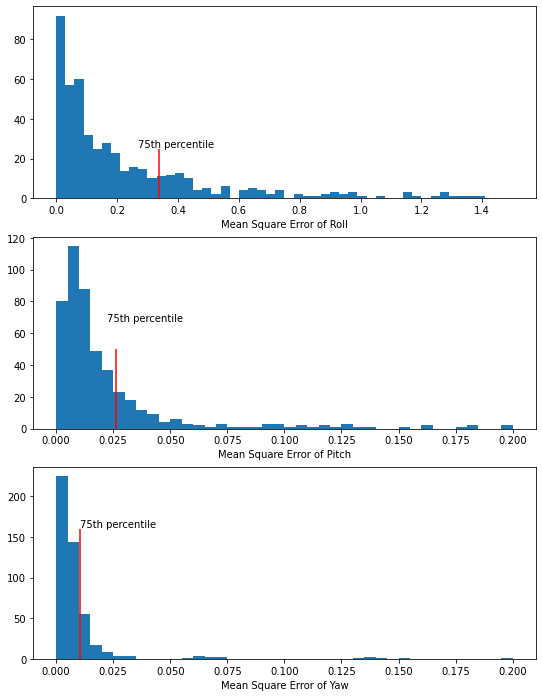

In [31]:
fig, (ax_rerr,ax_perr,ax_yerr) = plt.subplots(3, 1, figsize=(9, 12), sharex=False)

q_75_r = np.quantile(rpy_err[:,0], 0.75)
q_75_p = np.quantile(rpy_err[:,1], 0.75)
q_75_y = np.quantile(rpy_err[:,2], 0.75)

ax_rerr.vlines(q_75_r, 0, 25, "r")
ax_rerr.text(q_75_r - 0.07, 25+0.5, "75th percentile")
ax_rerr.hist(rpy_err[:,0], bins=50, range=(0,1.5))
ax_rerr.set_xlabel("Mean Square Error of Roll")

ax_perr.hist(rpy_err[:,1],bins=40, range=(0,0.2))
ax_yerr.text(q_75_p-0.004, 415, "75th percentile")
ax_perr.vlines(q_75_p, 0, 50, 'r')
ax_perr.set_xlabel("Mean Square Error of Pitch")


ax_yerr.hist(rpy_err[:,2],bins=40, range=(0,0.2))
ax_yerr.text(q_75_y, 160+2, "75th percentile")
ax_yerr.vlines(q_75_y, 0, 160, 'r')
ax_yerr.set_xlabel("Mean Square Error of Yaw")

## Additional Statistics


In [32]:
print(f'Means: {np.mean(rpy_err[:,0])} , {np.mean(rpy_err[:,1])}, {np.mean(rpy_err[:,2])}')
print(f'Medians: {np.median(rpy_err[:,0])} , {np.median(rpy_err[:,1])}, {np.median(rpy_err[:,2])}')
print(f'Max: {np.max(rpy_err[:,0])} , {np.max(rpy_err[:,1])}, {np.max(rpy_err[:,2])}')
print(f'Min: {np.min(rpy_err[:,0])} , {np.min(rpy_err[:,1])}, {np.min(rpy_err[:,2])}')
print(f'Standard deviations: {np.std(rpy_err[:,0])} , {np.std(rpy_err[:,1])}, {np.std(rpy_err[:,2])}')
print(f'75th percentiles: {q_75_r}, {q_75_p}, {q_75_y}')

Means: 0.29913543355364797 , 0.03421432682689106, 0.10550547337167518
Medians: 0.13237694295202246 , 0.012783057463713995, 0.0055954750166834315
Max: 3.662476353369355 , 0.6101830878594657, 4.930681759371874
Min: 0.0001235935288849821 , 0.0004679569216614431, 4.318200995636664e-05
Standard deviations: 0.4859844016012977 , 0.06790208672769543, 0.5252095790800316
75th percentiles: 0.3385978611721028, 0.026134986760029847, 0.010397082292167226


In [33]:
# Amazing results, how many times did we do really well?
count = 0
for i in range(num_sims):
    if ((rpy_err[i,0] < 0.05 and rpy_err[i,1] < 0.005) and rpy_err[i,2] < 0.005):
        count += 1

print(count)

25


## Large Scope Noise
This is a further test into how the system behaves if the scope has a lot more noise. The number of sims can be set to 1 with display=True if only one run is required.

In [34]:
robot = ae353_spacecraft.RobotSimulator(display=False, shootingstar = True, stars = np.array([[alpha1,delta1],[alpha2,delta2],[alpha3,delta3],[alpha4,delta4],[alpha5,delta5]]), scope_noise = 0.3)

In [35]:
# Run the simulation a hundred times
num_sims = 500
rpy_err_noisy = np.zeros((num_sims,3))
for j in range(num_sims):
    # Restore the simulation to its initial state
    robot.reset()
    # Restore the controller to its initial state
    controller.reset()

    # Choose how long we want to run the simulation, and
    # compute the corresponding number of time steps
    run_time = 30.0
    num_steps = int(run_time/robot.dt)

    # Create a dictionary in which to store results
    data = {
        't': np.empty(num_steps, dtype=float),
        'v': np.empty((4, num_steps), dtype=float),
        'p': np.empty((2 * len(robot.stars), num_steps), dtype=float),
        'tau': np.empty((4, num_steps), dtype=float),
        'rpy': np.empty((3, num_steps), dtype=float),
        'angvel': np.empty((3, num_steps), dtype=float),
        'xhat': np.empty((6, num_steps), dtype=float),
    }

    p = np.zeros(10) #CHANGE this when changing no. of stars
    v = np.zeros(4)
    # Run the simulation loop
    start_time = time.time()
    for step in range(num_steps):
        # Get the current time
        t = robot.dt * step
        pold = p
        vold = v
        # Get the sensor measurements
        p, v = robot.get_sensor_measurements()
        # Ensuring we don't get nan values
        for i in range(p.shape[0]):
            if np.isnan(p[i]):
                p[i] = pold[i]
        # Choose the actuator command (by running the controller)
        tau = controller.run(p, v)
        if tau.shape != (4, ):
            raise Exception(f'invalid desired torques: {tau}')
        
        # Get orientation and angular velocity as ground truth
        rpy, angvel = robot.get_rpy_and_angvel()
            
        # Log the data from this time step
        data['t'][step] = t
        data['v'][:, step] = v
        data['p'][:, step] = p
        data['tau'][:, step] = tau
        data['rpy'][:, step] = rpy
        data['angvel'][:, step] = angvel
        data['xhat'][:, step] = controller.xhat.flatten()
        
        # Send the actuator commands to robot and go forward one time step
        robot.set_actuator_commands(tau)
        robot.step(t=(start_time + (robot.dt * (step + 1))))
    rpy_err_noisy[j,0] += np.mean((data['rpy'][0, :])**2)
    rpy_err_noisy[j,1] += np.mean((data['rpy'][1, :])**2)
    rpy_err_noisy[j,2] += np.mean((data['rpy'][2, :])**2)
    if j%10 == 0:
        print(f'{j}/{num_sims}')
print(f'{num_sims}/{num_sims}')

0/500
10/500
20/500
30/500
40/500
50/500
60/500
70/500
80/500
90/500
100/500
110/500
120/500
130/500
140/500
150/500
160/500
170/500
180/500
190/500
200/500
210/500
220/500
230/500
240/500
250/500
260/500
270/500
280/500
290/500
300/500
310/500
320/500
330/500
340/500
350/500
360/500
370/500
380/500
390/500
400/500
410/500
420/500
430/500
440/500
450/500
460/500
470/500
480/500
490/500
500/500


Text(0.5, 0, 'Mean Square Error of Yaw (with noise)')

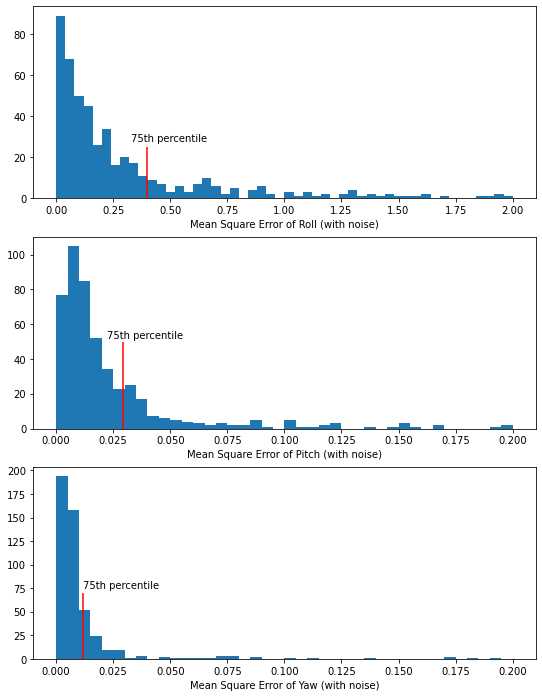

In [36]:
fig, (ax_rerr,ax_perr,ax_yerr) = plt.subplots(3, 1, figsize=(9, 12), sharex=False)

q_75_r_n = np.quantile(rpy_err_noisy[:,0], 0.75)
q_75_p_n = np.quantile(rpy_err_noisy[:,1], 0.75)
q_75_y_n = np.quantile(rpy_err_noisy[:,2], 0.75)

ax_rerr.vlines(q_75_r_n, 0, 25, "r")
ax_rerr.text(q_75_r_n - 0.07, 25+3, "75th percentile")
ax_rerr.hist(rpy_err_noisy[:,0], bins=50,range = (0,2))
ax_rerr.set_xlabel("Mean Square Error of Roll (with noise)")

ax_perr.hist(rpy_err_noisy[:,1],bins=40, range=(0,0.2))
ax_yerr.text(q_75_p_n - 0.007, 340, "75th percentile")
ax_perr.vlines(q_75_p_n, 0, 50, 'r')
ax_perr.set_xlabel("Mean Square Error of Pitch (with noise)")


ax_yerr.hist(rpy_err_noisy[:,2],bins=40, range=(0,0.2))
ax_yerr.text(q_75_y_n, 75, "75th percentile")
ax_yerr.vlines(q_75_y_n, 0, 70, 'r')
ax_yerr.set_xlabel("Mean Square Error of Yaw (with noise)")



## Additional Statistics

In [37]:
print(f'Means: {np.mean(rpy_err_noisy[:,0])} , {np.mean(rpy_err_noisy[:,1])}, {np.mean(rpy_err_noisy[:,2])}')
print(f'Medians: {np.median(rpy_err_noisy[:,0])} , {np.median(rpy_err_noisy[:,1])}, {np.median(rpy_err_noisy[:,2])}')
print(f'Max: {np.max(rpy_err_noisy[:,0])} , {np.max(rpy_err_noisy[:,1])}, {np.max(rpy_err_noisy[:,2])}')
print(f'Min: {np.min(rpy_err_noisy[:,0])} , {np.min(rpy_err_noisy[:,1])}, {np.min(rpy_err_noisy[:,2])}')
print(f'Standard deviations: {np.std(rpy_err_noisy[:,0])} , {np.std(rpy_err_noisy[:,1])}, {np.std(rpy_err_noisy[:,2])}')
print(f'75th percentiles: {q_75_r_n}, {q_75_p_n}, {q_75_y_n}')

Means: 0.40319399568178904 , 0.03409295799192606, 0.13895208507565826
Medians: 0.158707034911644 , 0.013829582428859321, 0.00628052596878391
Max: 4.699043104514914 , 0.5718087582703731, 4.644150194618874
Min: 0.0033096668944413163 , 0.0001417354208148443, 0.00010308131769085807
Standard deviations: 0.6616329539815612 , 0.06284574179843692, 0.5996199137027969
75th percentiles: 0.39700666352312625, 0.02945668426019639, 0.011768680475147389
